# 1 - Classification model

Construa um classificador e identifique quais variáveis exercem maior impacto sobre o “target” e informe o porquê interpretando os resultados obtidos. 

métricas: precision, recall e F1-score;

dados: classification_data.zip;


### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as ss
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions

In [2]:
plt.style.use(["seaborn-notebook"])
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    confusion_matrix,
    roc_auc_score,
    RocCurveDisplay
)

## Data Inspection

In [4]:
df_train = pd.read_csv("./classification_data/classification_train.csv")
print(f"O dataset tem {df_train.shape[0]} linhas e {df_train.shape[1]} colunas.")
df_train.head()

O dataset tem 670 linhas e 3 colunas.


,x1,x2,target
0,1.934224,-0.111822,1
1,1.767383,-0.976402,1
2,0.937101,-0.085633,1
3,1.340732,0.166960,1
4,-0.199901,-0.155204,1


In [5]:
df_test = pd.read_csv("./classification_data/classification_test.csv")
print(f"O dataset tem {df_test.shape[0]} linhas e {df_test.shape[1]} colunas.")
df_test.head()

O dataset tem 330 linhas e 3 colunas.


,x1,x2,target
0,1.114204,-0.434321,1
1,-1.238490,0.521390,0
2,-0.091781,-0.169471,1
3,0.298820,0.076368,0
4,-0.265779,0.479812,1


In [6]:
split_size = round(df_train.shape[0] / (df_train.shape[0] + df_test.shape[0]) * 100, 2)
print(
    f" O método Holdout realizado previamente entre treino e teste é de \
| {split_size} : {100-split_size} |"
)

 O método Holdout realizado previamente entre treino e teste é de | 67.0 : 33.0 |


In [7]:
X_cols = df_train.drop(columns='target').columns

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 670 entries, 0 to 669
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      670 non-null    float64
 1   x2      670 non-null    float64
 2   target  670 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 15.8 KB


In [9]:
df_train.isnull().sum()

x1        0
x2        0
target    0
dtype: int64

In [10]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330 entries, 0 to 329
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      330 non-null    float64
 1   x2      330 non-null    float64
 2   target  330 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 7.9 KB


In [11]:
df_test.isnull().sum()

x1        0
x2        0
target    0
dtype: int64

array([[<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>]], dtype=object)

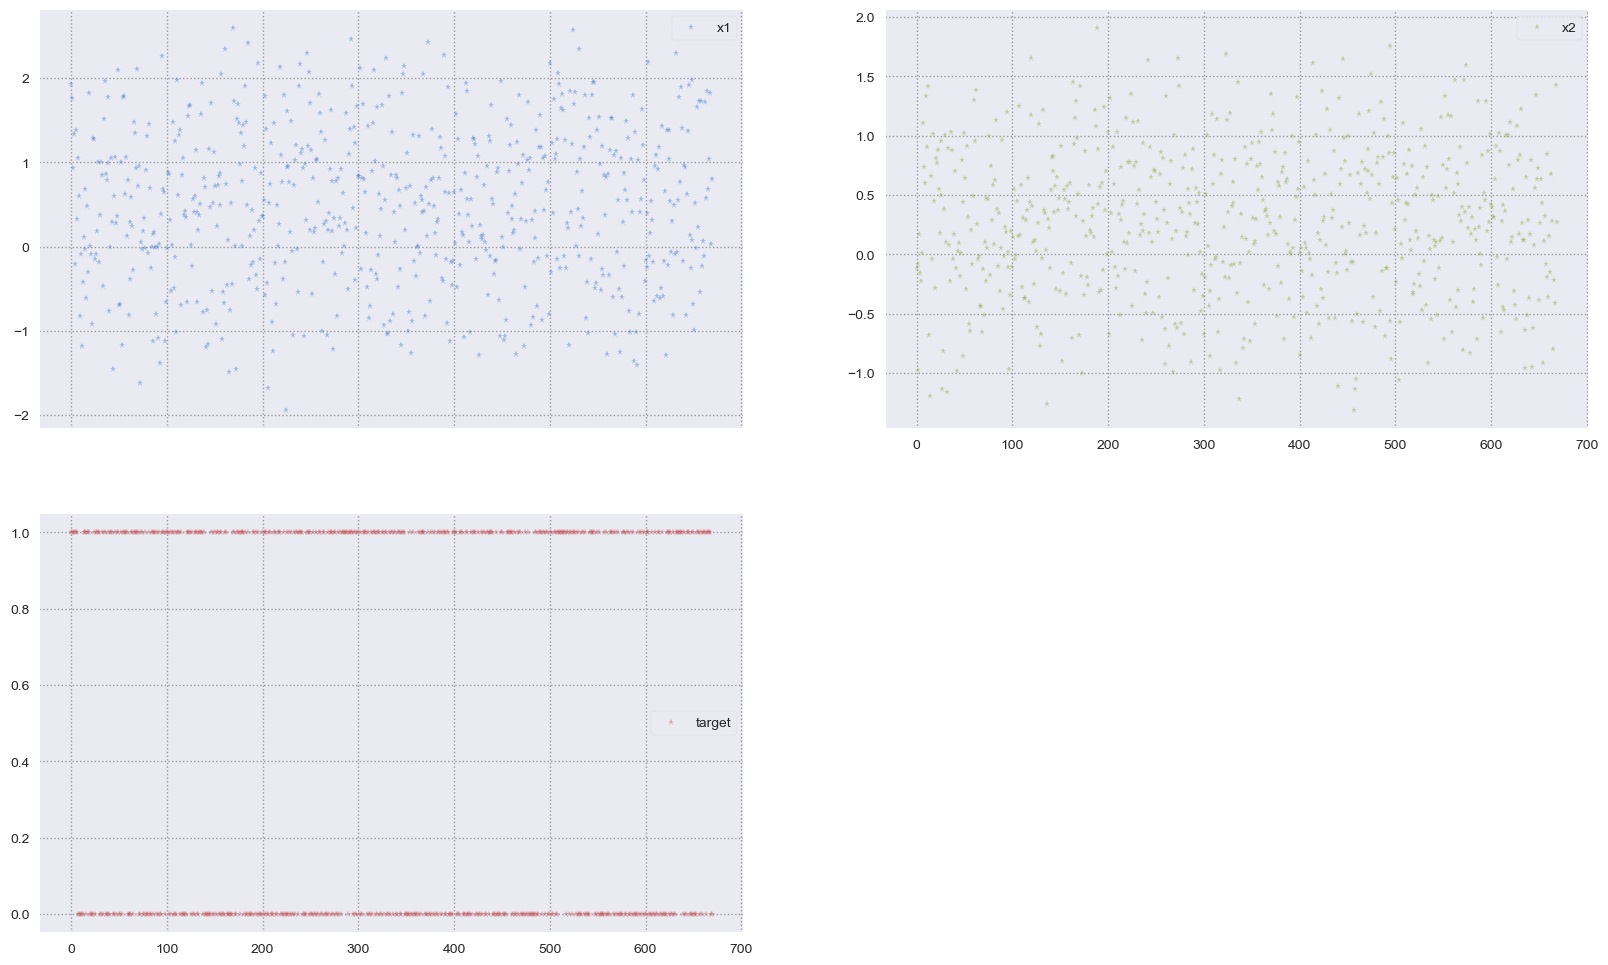

In [12]:
df_train.plot(lw=0,
        marker='*',
        subplots=True,
        layout=(-1, 2),
        figsize=(20, 12),
        alpha=.4,
        markersize=5)

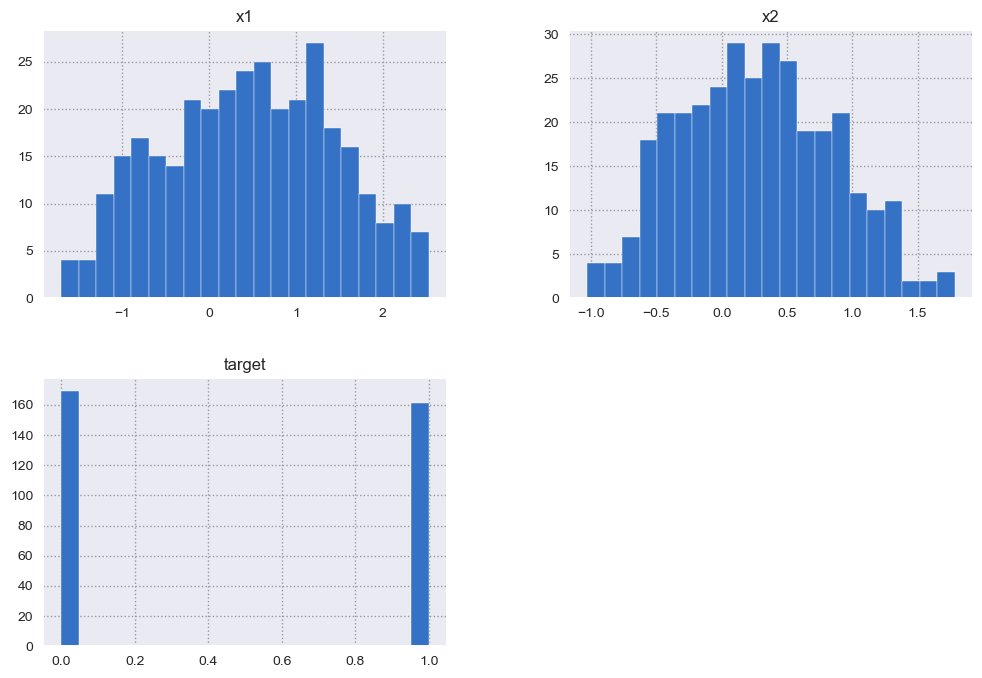

In [13]:
%matplotlib inline
df_test.hist(bins=21, figsize=(12, 8));

In [14]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
x1,670.0,0.481824,0.914772,-1.939767,-0.169615,0.492489,1.159680,2.590410
x2,670.0,0.262611,0.615023,-1.313970,-0.159189,0.275538,0.717589,1.904169
target,670.0,0.505970,0.500338,0.000000,0.000000,1.000000,1.000000,1.000000


In [15]:
df_viz = df_train.copy()

Identificando outliers

In [16]:
def outlier_iqr(dados, feature):
    Q1 = dados[feature].quantile(0.25)
    Q3 = dados[feature].quantile(0.75)
    IQR = Q3 - Q1
    LI = Q1 - 1.5 * IQR
    LS = Q3 + 1.5 * IQR
    outliers = dados[(dados[feature] < LI) | (dados[feature] > LS)]
    df_viz.boxplot(column=feature, return_type="axes", figsize=(6, 4), grid=True)
    plt.show()
    return outliers

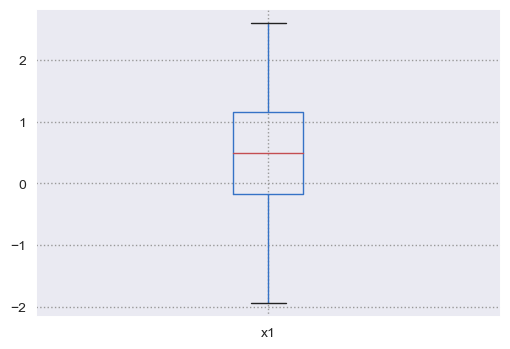

nº de outliers 0 


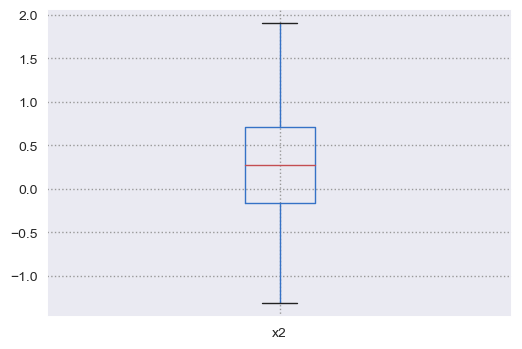

nº de outliers 0 


In [17]:
outliers = set()
for i in X_cols:
    v = outlier_iqr(df_train, i)
    outliers.update(v.index)
    print("nº de outliers", len(v), "\n========")

    sem outliers

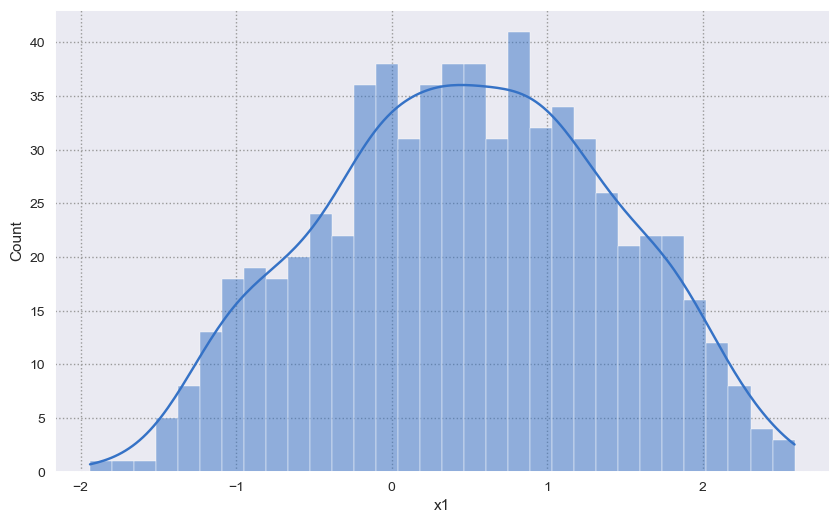

In [18]:
plt.figure(figsize=(10, 6))
sns.histplot(df_viz["x1"], bins=32, kde=True, color="b")
plt.show()

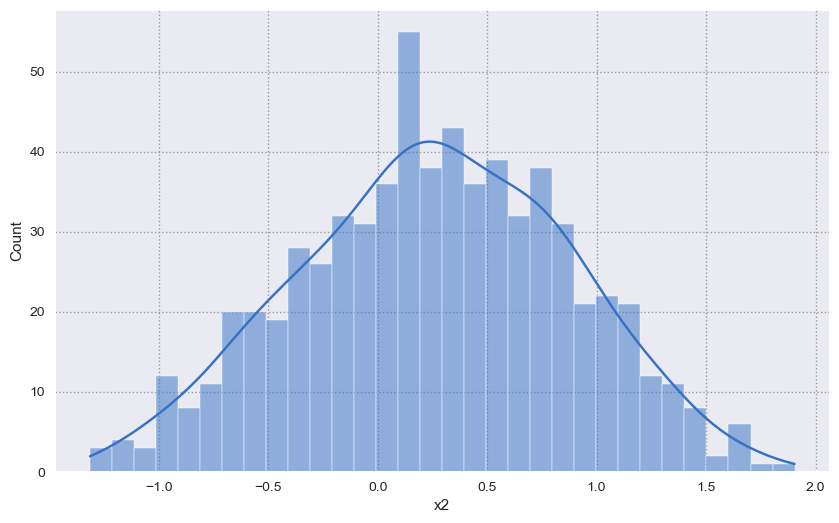

In [19]:
plt.figure(figsize=(10, 6))
sns.histplot(df_viz["x2"], bins=32, kde=True, color="b")
plt.show()

### Teste de Normalidade _Shapiro-Wilk_

In [20]:
from scipy.stats import shapiro

Surpreendentemente, as duas features aparentam representar o comportamento muito similar ao de Gaussianas, fato que pode ser comprovado com o teste de _Shapiro-Wilk_ em torno de algumas amostras

#### Bootstrapping

In [36]:
sample_1 = df_train.sample(frac=0.33)
sample_2 = df_train.sample(frac=0.33)
sample_3 = df_train.sample(frac=0.33)
sample_4 = df_train.sample(frac=0.33)
sample_5 = df_train.sample(frac=0.33)

samples = [sample_1, sample_2, sample_3, sample_4, sample_5]

#### Hipóteses Nula e Alternativa

$(\text{H 0})$: A distribuição não vem de uma curva Normal

$(\text{H 1})$: A distribuição segue a curva Normal

In [37]:
normal = 0
anormal = 0

for i in samples:
  sc,p = shapiro(i['x1'])
  print('sc=%.3f, p=%.3f' %(sc,p))
  if p > .05:
    normal += 1
  else:
    anormal += 1

print("Quantidade de normais: " + str(normal))
print("Quantidade de NAO normais: " + str(anormal))

sc=0.991, p=0.223
sc=0.988, p=0.060
sc=0.989, p=0.082
sc=0.992, p=0.273
sc=0.991, p=0.195
Quantidade de normais: 5
Quantidade de NAO normais: 0


In [38]:
normal = 0
anormal = 0

for i in samples:
  sc,p = shapiro(i['x2'])
  print('sc=%.3f, p=%.3f' %(sc,p))
  if p > 0.05:
    normal += 1
  else:
    anormal += 1

print("Quantidade de normais: " + str(normal))
print("Quantidade de NAO normais: " + str(anormal))

sc=0.992, p=0.274
sc=0.991, p=0.178
sc=0.991, p=0.192
sc=0.992, p=0.287
sc=0.990, p=0.115
Quantidade de normais: 5
Quantidade de NAO normais: 0


#### Insight 1:
Felizmente, as distribuições são normais e não apresentam outliers pelo método de _Intervalo Interquartil_ ($\text{IQR}$), o que permite o uso eficaz de um modelo de __Árvore de Decisão__

## Data Preprocessing

Como não há valores ausente e nem há necessidade de escalar os valores em um modelo de Árvore ($\text{D.T.}$) , basta finalizar o método Holdout na base de dados.

In [24]:
X_train = df_train.loc[:, ["x1", "x2"]]
X_train.to_numpy()
display(X_train.head(2))
y_train = df_train["target"].values.reshape(-1, 1)
print(y_train[:3])

X_test = df_test.loc[:, ["x1", "x2"]]
X_train.to_numpy()
y_test = df_test["target"].values.reshape(-1, 1)

,x1,x2
0,1.934224,-0.111822
1,1.767383,-0.976402


[[1]
 [1]
 [1]]


## Decision Tree Classifier

In [25]:
dt = DecisionTreeClassifier(
    random_state=42, max_depth=3, criterion="gini", splitter="best"
)

dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [26]:
dt.score(X_test, y_test)

0.8454545454545455

O modelo acerta em média $\approx 85\%$ das predições na base de teste

### metrics

#### 1. Confusion Matrix

In [27]:
# pegar os valores preditos de X_test
y_pred_test = dt.predict(X_test)

In [28]:
cm = confusion_matrix(y_test, y_pred_test)

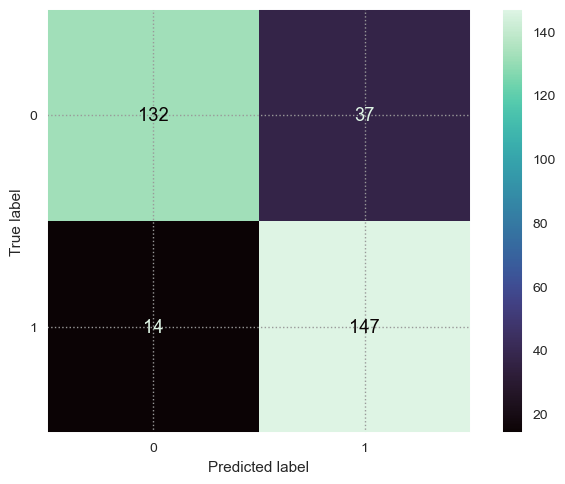

In [29]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="mako")
plt.show()

In [30]:
tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]

#### 2. Precision (precisão)

In [31]:
precision = tp / (tp + fp)
precision

0.7989130434782609

#### 3. Recall (sensibilidade)

In [32]:
recall = tp / (tp + fn)
recall

0.9130434782608695

#### 4. F1_score

In [33]:
f1_score = 2 * (precision *recall / (precision + recall))
f1_score

0.8521739130434782

#### 5. Curva ROC

In [34]:
roc_auc_score(y_test, y_pred_test)

0.8470542835091329

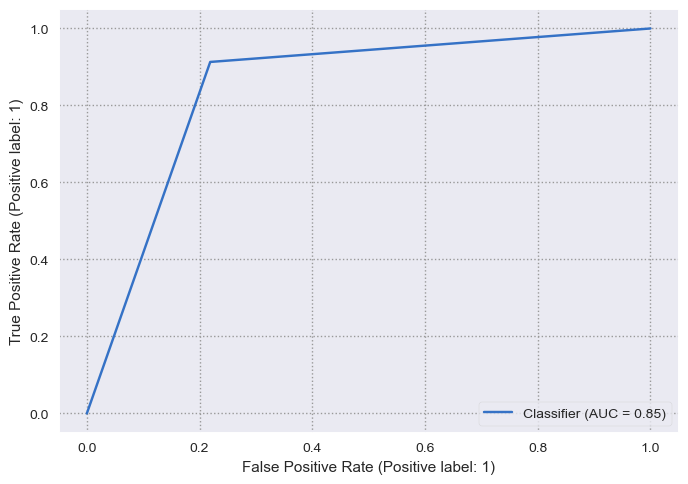

In [35]:
RocCurveDisplay.from_predictions(y_test, y_pred_test)